In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_confusion_matrix

Now we will read the CSV to pandas Dataframe

In [35]:
train_file = pd.read_csv('aug_train.csv')
test_file = pd.read_csv('aug_test.csv')

train_file.head(3)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0


### Data Analysis

<br>

In [40]:
percentages = train_file.isna().sum().reset_index().rename(columns={'index': 'Column', 0:'Missing'})
percentages['Percentage'] = percentages['Missing']/train_file.shape[0]*100

print(f'Missing data per feature: \n\n', percentages)

Missing data per feature: 

                     Column  Missing  Percentage
0              enrollee_id        0    0.000000
1                     city        0    0.000000
2   city_development_index        0    0.000000
3                   gender     4508   23.530640
4      relevent_experience        0    0.000000
5      enrolled_university      386    2.014824
6          education_level      460    2.401086
7         major_discipline     2813   14.683161
8               experience       65    0.339284
9             company_size     5938   30.994885
10            company_type     6140   32.049274
11            last_new_job      423    2.207955
12          training_hours        0    0.000000
13                  target        0    0.000000


In [41]:
def plot(data, column):
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    perc = percentages.query(f'Column == "{column}"')['Percentage'].values
    sns.countplot(data=data, x=column, ax=ax[0])
    ax[1].pie(train_file[column].value_counts().values, labels=train_file[column].value_counts().index, autopct='%1.1f%%')
    fig.tight_layout()
    fig.suptitle(f'Column: \'{column}\'    -    Missing data: {perc[0]:.2f}%', fontsize=30)
    fig.subplots_adjust(top=0.88)
    fig.show()

<ipython-input-41-51c9f87695a3>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


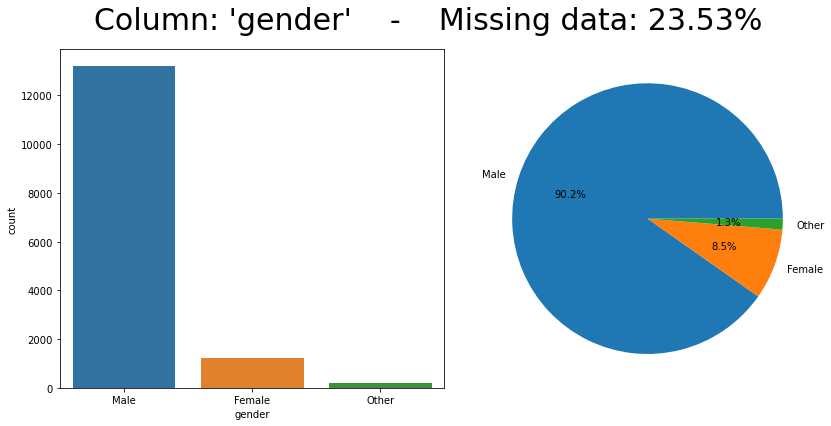

In [42]:
# plot(train_file,'gender') 
# plot(train_file, 'relevent_experience') 
# plot(train_file, 'enrolled_university') 
# plot(train_file, 'education_level') 
# plot(train_file, 'major_discipline') 
# plot(train_file, 'experience') 
# plot(train_file, 'company_size') 
# plot(train_file, 'company_type') 
# plot(train_file, 'last_new_job') 
# plot(train_file, 'training_hours') 

<br>

### PreProcessing 

In [ ]:
train_file = train_file.drop(['company_size','company_type'],axis=1)
test_file = test_file.drop(['company_size','company_type'],axis=1)

In [ ]:
print('Train file NAN values: \n', train_file.isnull().sum())
print('Test file NAN values: \n', test_file.isnull().sum())

In [7]:
def impute(DataFrame, ColName):
    most_frequent_category= DataFrame[ColName].mode()[0]
#     Replace unknown values with most occured category
    DataFrame[ColName].fillna(most_frequent_category, inplace=True)

In [43]:
for i in train_file.select_dtypes(include = 'object').columns:
    impute(train_file,i)

for i in test_file.select_dtypes(include = 'object').columns:
    impute(test_file,i)

train_file.head(10)
train_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  19158 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     19158 non-null  object 
 6   education_level         19158 non-null  object 
 7   major_discipline        19158 non-null  object 
 8   experience              19158 non-null  object 
 9   company_size            19158 non-null  object 
 10  company_type            19158 non-null  object 
 11  last_new_job            19158 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

<br>

### LabelEncoding 

In [13]:
objList = train_file.select_dtypes(include='object').columns
print("Categorical columns: ", objList )

Categorical columns:  Index(['city', 'gender', 'relevent_experience', 'enrolled_university',
       'education_level', 'major_discipline', 'experience', 'company_size',
       'company_type', 'last_new_job'],
      dtype='object')


In [14]:
le = preprocessing.LabelEncoder()
train_encoded = train_file.copy()
test_encoded = test_file.copy()
for feat in objList:
    train_encoded[feat] = le.fit_transform(train_file[feat].astype(str))
    test_encoded[feat] = le.fit_transform(test_file[feat].astype(str))

In [15]:
test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   int64  
 2   city_development_index  2129 non-null   float64
 3   gender                  2129 non-null   int64  
 4   relevent_experience     2129 non-null   int64  
 5   enrolled_university     2129 non-null   int64  
 6   education_level         2129 non-null   int64  
 7   major_discipline        2129 non-null   int64  
 8   experience              2129 non-null   int64  
 9   company_size            2129 non-null   int64  
 10  company_type            2129 non-null   int64  
 11  last_new_job            2129 non-null   int64  
 12  training_hours          2129 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 216.4 KB


In [16]:
X = train_encoded.drop('target', axis=1)
Y = train_encoded.target

<br>

### Upsampling Data using SMOTE

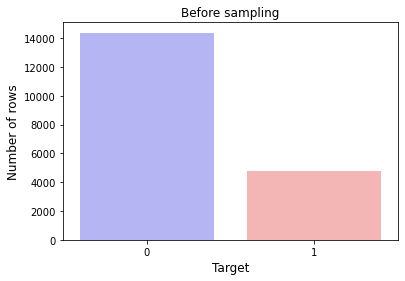

In [17]:
plt.figure(figsize =(6,4))
sns.barplot(Y.value_counts().index.astype(int),Y.value_counts().values,palette='bwr')
plt.ylabel('Number of rows', fontsize=12)
plt.xlabel('Target', fontsize=12)
plt.title('Before sampling')
plt.show()

In [19]:
oversample = SMOTE()
smote = SMOTE(random_state=0)
x_oversample, y_oversample = smote.fit_resample(X,Y)

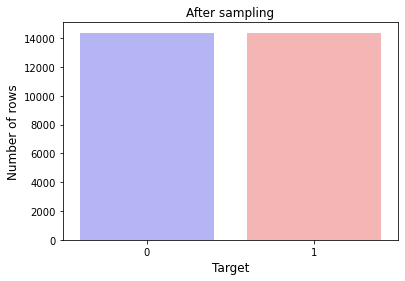

In [20]:
plt.figure(figsize=(6, 4))
sns.barplot(y_oversample.value_counts().index.astype(int),
            y_oversample.value_counts().values, palette='bwr')
plt.ylabel('Number of rows', fontsize=12)
plt.xlabel('Target', fontsize=12)
plt.title('After sampling')
plt.show()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(x_oversample,y_oversample,test_size=0.3,random_state=42)

### Decision Tree Classifier

              precision    recall  f1-score   support

         0.0       0.75      0.74      0.74      4325
         1.0       0.74      0.75      0.74      4304

    accuracy                           0.74      8629
   macro avg       0.74      0.74      0.74      8629
weighted avg       0.74      0.74      0.74      8629



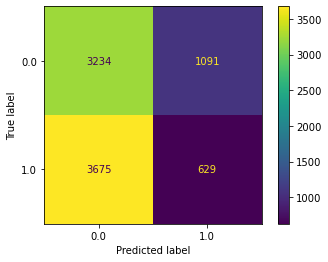

In [24]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred, zero_division=0))
metrics.confusion_matrix(y_test,y_pred)
plot_confusion_matrix(rft, X_test, y_test)  
plt.show()

### Decision Tree Classifier With Hyperparameter Tuning


              precision    recall  f1-score   support

         0.0       0.77      0.76      0.77      4325
         1.0       0.77      0.77      0.77      4304

    accuracy                           0.77      8629
   macro avg       0.77      0.77      0.77      8629
weighted avg       0.77      0.77      0.77      8629

[[3303 1022]
 [ 976 3328]]


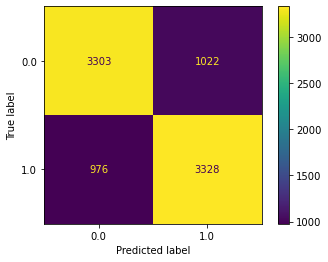

In [26]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Tuned Decision Tree Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'min_impurity_decrease': 0, 'min_samples_split': 2}
# param_list = {'criterion': ['gini', 'entropy'],
#                   'max_depth': [10, None],
#                   'class_weight': ['balanced', None],
#                   'min_samples_split': [2],
#                   'min_impurity_decrease': [*range(0, 20, 1)]
                  
tree = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,min_impurity_decrease=0, min_samples_split=2)

# tree_cv = GridSearchCV(tree, param_list, cv=5)

tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

# print("Tuned Decision Tree Parameters: {}".format(tree.best_params_))
print()
print(metrics.classification_report(y_test, y_pred, zero_division=0))

print(metrics.confusion_matrix(y_test, y_pred))

plot_confusion_matrix(tree,X_test,y_test)
plt.show()

## Random Forest Classifier

              precision    recall  f1-score   support

         0.0       0.82      0.81      0.81      4325
         1.0       0.81      0.82      0.81      4304

    accuracy                           0.81      8629
   macro avg       0.81      0.81      0.81      8629
weighted avg       0.81      0.81      0.81      8629



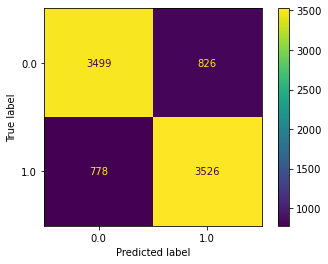

In [22]:
rft = RandomForestClassifier()
rft = rft.fit(X_train,y_train)
y_pred = rft.predict(X_test)
print(metrics.classification_report(y_test, y_pred, zero_division=0))
metrics.confusion_matrix(y_test,y_pred)

plot_confusion_matrix(rft, X_test, y_test)  
plt.show()